# 03 - Exploratory Data Analysis (EDA)

## 1. Load Cleaned Data


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
from src.eda import plot_univariate, plot_bivariate, plot_correlation_matrix

In [6]:
# Load the cleaned dataset
df = pd.read_csv('../data/processed/credit_card_default_cleaned.csv')

# Rename column for clarity
df.rename(columns={'default': 'default_payment', 'PAY_0': 'PAY_1'}, inplace=True)

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 2. Univariate Analysis
Explore the distribution of key features.


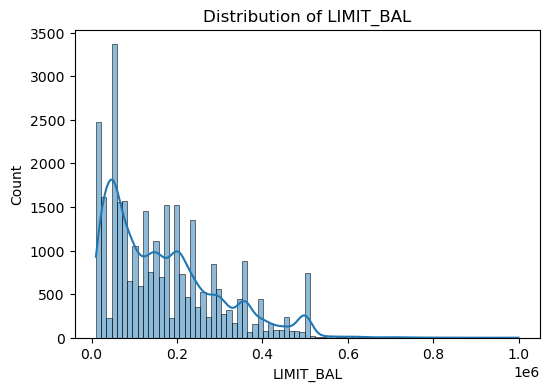

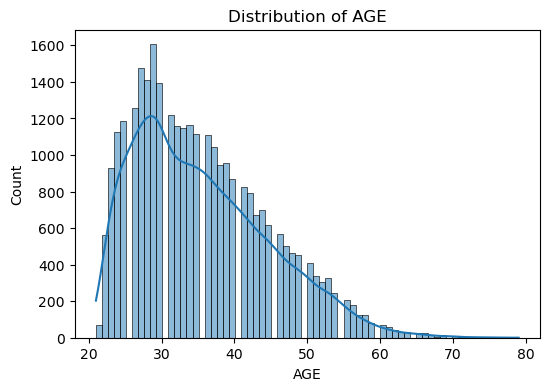

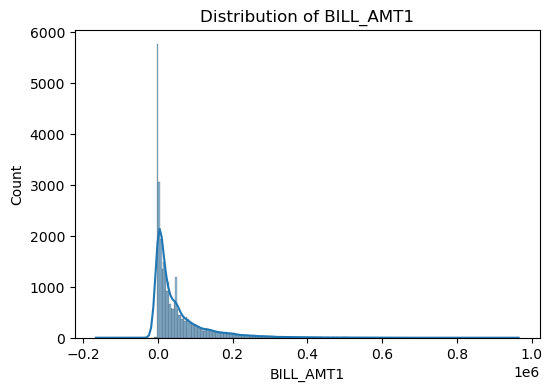

In [7]:
plot_univariate(df, 'LIMIT_BAL')
plot_univariate(df, 'AGE')
plot_univariate(df, 'BILL_AMT1')

LIMIT_BAL and BILL_AMT1 are right-skewed; AGE has a near-normal distribution with a peak in late 20s to early 30s.

## 3. Bivariate Analysis
Explore relationships between features and the target variable.


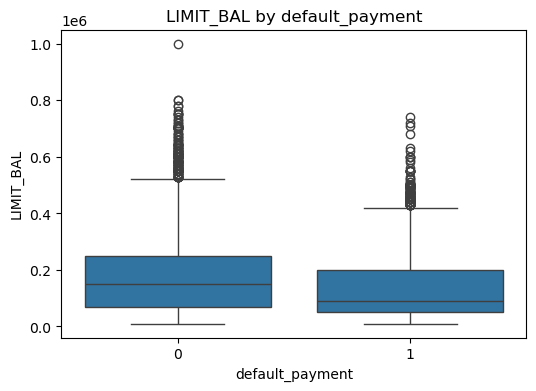

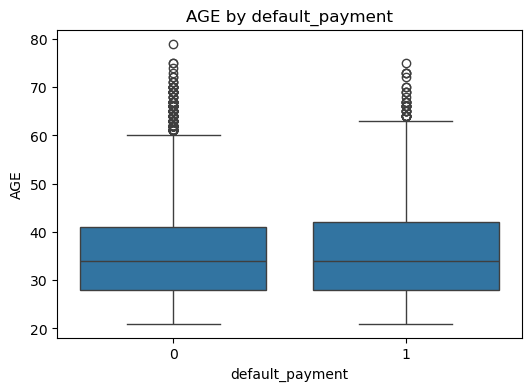

In [8]:
plot_bivariate(df, 'LIMIT_BAL', 'default_payment')
plot_bivariate(df, 'AGE', 'default_payment')

Default rate tends to be slightly higher in lower LIMIT_BAL segments and younger age groups.

## 4. Correlation Analysis
Visualize the correlation matrix for all features.


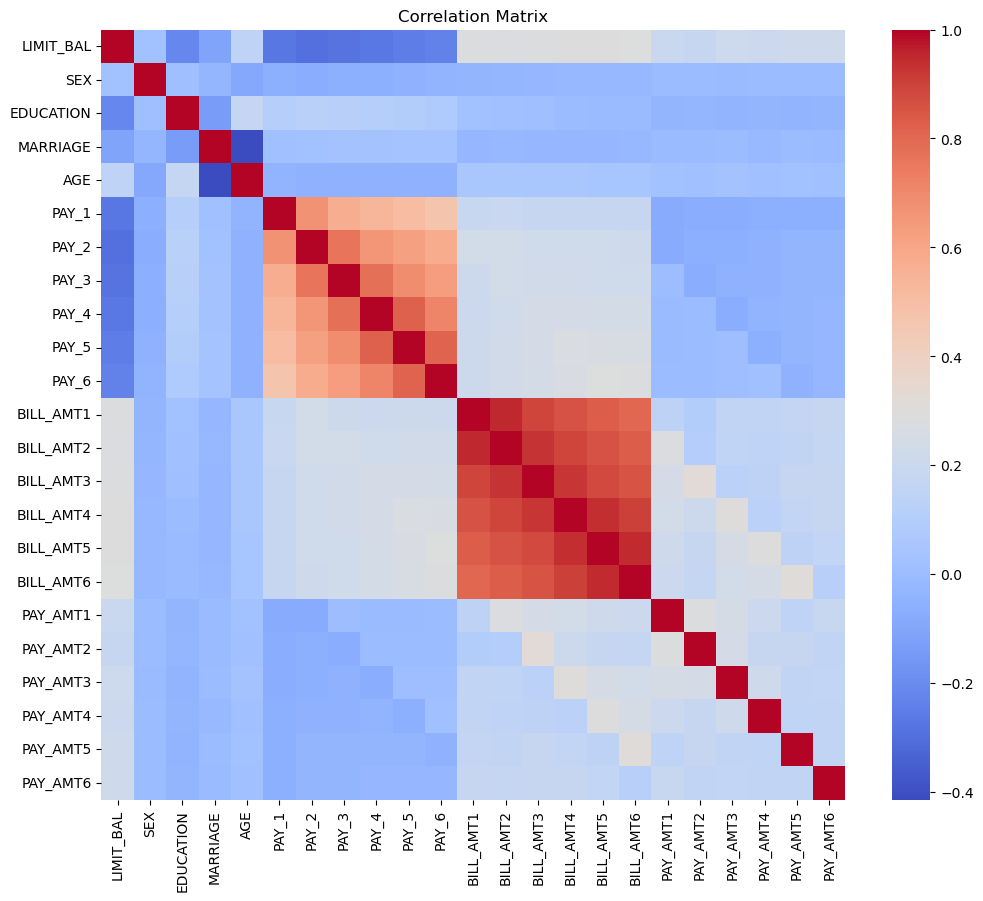

In [9]:
plot_correlation_matrix(df.drop(columns=['default_payment']))

Strong positive correlation among bill amounts and payment amounts over time.

## 5. Outlier analysis



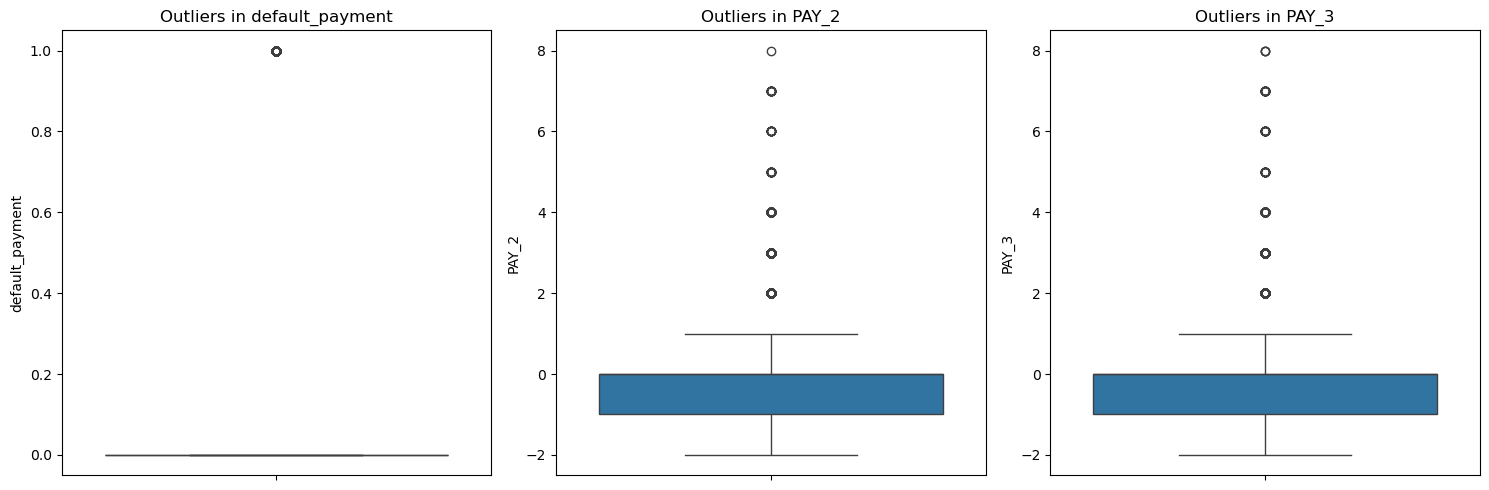

In [10]:
# Compute IQR for each numeric column
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
outlier_summary = []

for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    num_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary.append((col, Q1, Q3, IQR, lower, upper, num_outliers))

outlier_df = pd.DataFrame(outlier_summary, columns=['Column', 'Q1', 'Q3', 'IQR', 'Lower', 'Upper', 'Num_Outliers'])
outlier_df = outlier_df.sort_values(by='Num_Outliers', ascending=False)

# Plot top outliers
top_outliers = outlier_df.head(3)['Column']
plt.figure(figsize=(15, 5))
for i, col in enumerate(top_outliers):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

Features like default, PAY_2, PAY_3, and BILL_AMT series contain heavy outliers that need treatment.

In [11]:
cols_to_cap = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
               'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
               'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

for col in cols_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    df[col] = df[col].clip(lower=lower, upper=upper)

Capped high-impact outliers while retaining the full dataset.

## 6. Data Cleaning

### Fixing Categorical Labels

In [12]:
df['MARRIAGE'].value_counts()

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

<Axes: xlabel='MARRIAGE'>

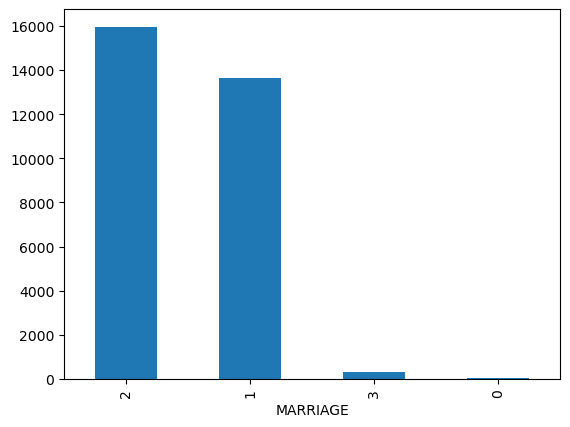

In [13]:
df.MARRIAGE.value_counts().plot(kind = 'bar')

In [14]:
# MARRIAGE values: Replace 0 with 3 (assumed as others)
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3

In [15]:
df.SEX.value_counts()

SEX
2    18112
1    11888
Name: count, dtype: int64

In [16]:
df.EDUCATION.value_counts()

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

<Axes: xlabel='EDUCATION'>

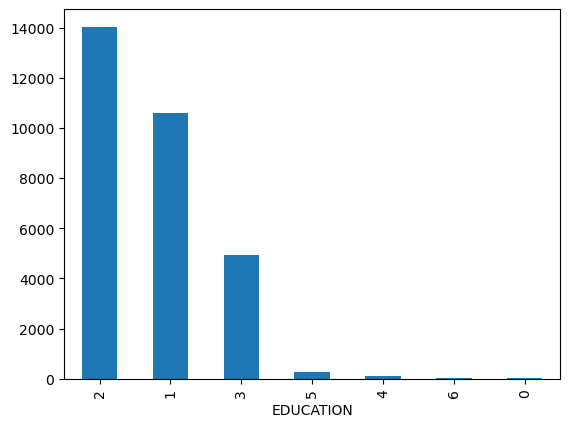

In [17]:
df.EDUCATION.value_counts().plot(kind = "bar")

In [18]:
# EDUCATION values: Group 0, 5, 6 into 4 (others)
df.loc[df.EDUCATION.isin([0, 5, 6]), 'EDUCATION'] = 4

In [19]:
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

### Numerical variables

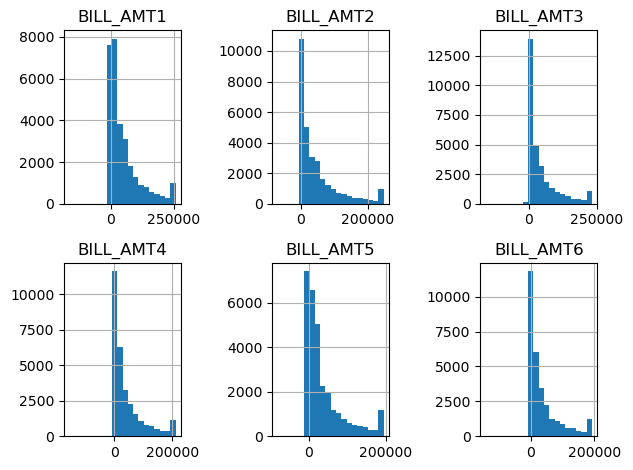

In [20]:
bills = df[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
draw_histograms(bills, bills.columns, 2, 3, 20)

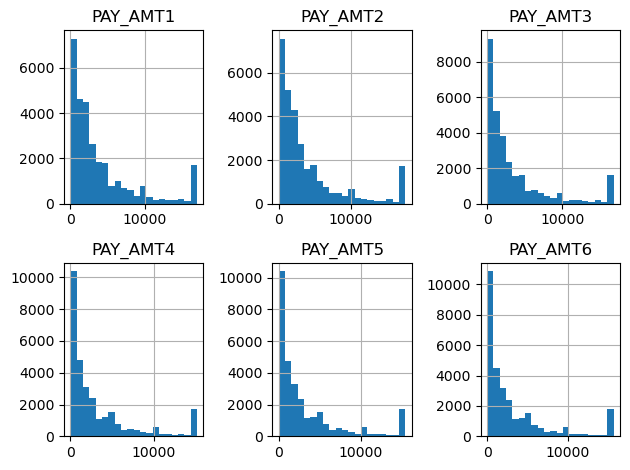

In [21]:
pay = df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
draw_histograms(pay, pay.columns, 2, 3, 20)

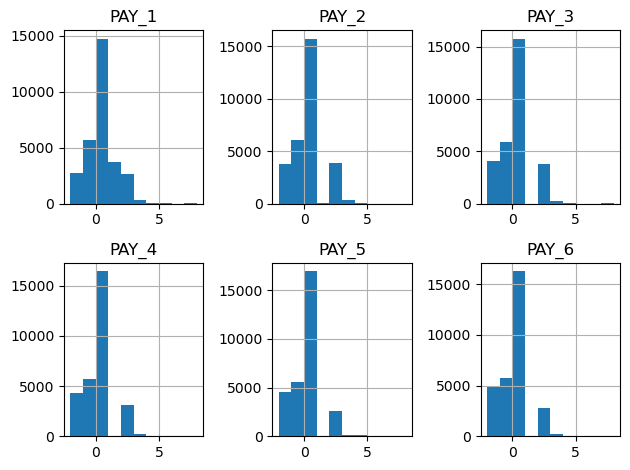

In [22]:
late = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
draw_histograms(late, late.columns, 2, 3, 10)

<Axes: >

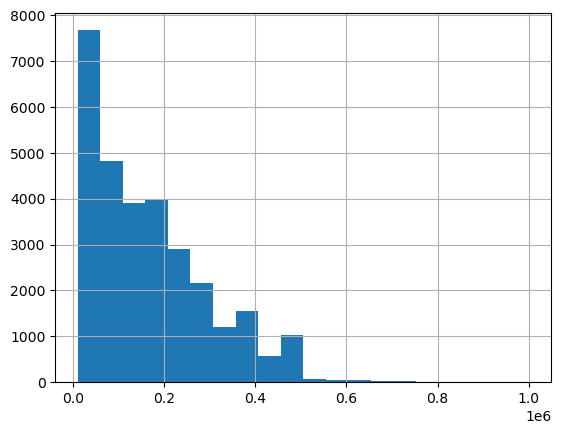

In [23]:
df.LIMIT_BAL.hist(bins = 20)

## 7. Feature Engineering

#### PAY_X Normalization

In [24]:
# PAY_X Normalization (turn -1, -2, 0 → 0; all positives → 1)
for i in range(1, 7):
    df[f'PAY_{i}'] = df[f'PAY_{i}'].apply(lambda x: 1 if x > 0 else 0)

#### Combined SEX & MARRIAGE

In [25]:
df.groupby(['SEX', 'default_payment']).size()

SEX  default_payment
1    0                   9015
     1                   2873
2    0                  14349
     1                   3763
dtype: int64

In [26]:
gender = df.groupby(['SEX', 'default_payment']).size().unstack(1)

In [28]:
pd.crosstab(df.SEX, df.default_payment)

default_payment,0,1
SEX,,
1,9015,2873
2,14349,3763


<Axes: xlabel='SEX'>

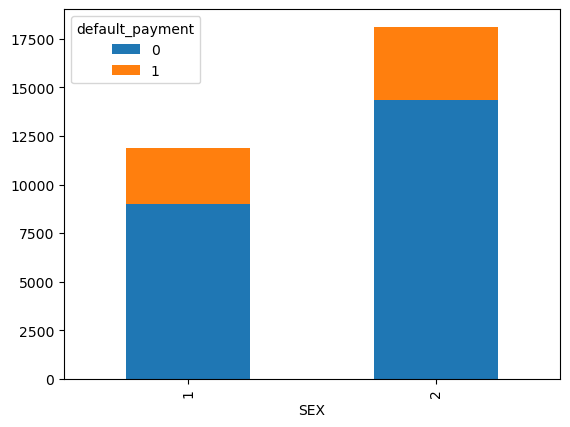

In [29]:
gender.plot(kind='bar', stacked = True)

In [30]:
gender['perc'] = (gender[1]/(gender[0] + gender[1])) 

In [31]:
gender

default_payment,0,1,perc
SEX,,,
1,9015,2873,0.241672
2,14349,3763,0.207763


In [32]:
df['SE_MA'] = df.SEX * df.MARRIAGE

#### Age Grouping + Combined Features

<Axes: >

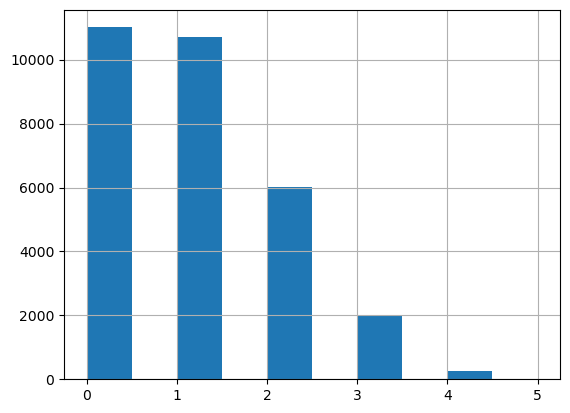

In [33]:
df['AgeBin'] = pd.cut(df['AGE'], bins=[20, 30, 40, 50, 60, 70, 81], labels=False)
df.AgeBin.hist()

In [34]:
df['SE_AG'] = df['SEX'] * 5 + df['AgeBin'].fillna(0).astype(int)

## 8. Behavioral Features

#### Clients with no activity

In [36]:
for i in range(1, 7):
    df[f'Client_{i}'] = 1
    condition = (df[f'PAY_{i}'] == 0) & (df[f'BILL_AMT{i}'] == 0) & (df[f'PAY_AMT{i}'] == 0)
    df.loc[condition, f'Client_{i}'] = 0

#### Average Expenditure Trend

In [37]:
for i in range(5, 0, -1):
    df[f'Avg_exp_{6-i}'] = sum(
        df[f'BILL_AMT{j}'] - (df[f'BILL_AMT{j+1}'] - df[f'PAY_AMT{j}'])
        for j in range(6-i, 6)
    ) / i

#### Closeness to Limit

In [38]:
for i in range(1, 7):
    df[f'Closeness_{i}'] = (df['LIMIT_BAL'] - df[f'BILL_AMT{i}']) / df['LIMIT_BAL']

 These behavioral indicators give insight into customer repayment behavior and credit utilization, which are valuable for prediction models.

In [41]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,Avg_exp_2,Avg_exp_3,Avg_exp_4,Avg_exp_5,Closeness_1,Closeness_2,Closeness_3,Closeness_4,Closeness_5,Closeness_6
0,20000,2,2,1,24,1,1,0,0,0,...,947.75,229.666667,0.0,0.0,0.804350,0.844900,0.965550,1.000000,1.000000,1.000000
1,120000,2,2,2,26,0,1,0,0,0,...,366.00,473.666667,505.5,194.0,0.977650,0.985625,0.977650,0.972733,0.971208,0.972825
2,90000,2,2,2,34,0,0,0,0,0,...,744.50,336.666667,391.0,399.0,0.675122,0.844144,0.849344,0.840767,0.833911,0.827233
3,50000,2,2,1,37,0,0,0,0,0,...,6018.50,7704.333333,468.0,481.0,0.060200,0.035340,0.014180,0.433720,0.420820,0.409060
4,50000,1,2,1,57,0,0,0,0,0,...,5932.25,12131.000000,5749.0,704.0,0.827660,0.886600,0.283300,0.581200,0.617080,0.617380


In [42]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_payment', 'SE_MA', 'AgeBin', 'SE_AG', 'Client_1', 'Client_2',
       'Client_3', 'Client_4', 'Client_5', 'Client_6', 'Avg_exp_1',
       'Avg_exp_2', 'Avg_exp_3', 'Avg_exp_4', 'Avg_exp_5', 'Closeness_1',
       'Closeness_2', 'Closeness_3', 'Closeness_4', 'Closeness_5',
       'Closeness_6'],
      dtype='object')

In [43]:
df.to_csv('../data/processed/credit_card_default_processed.csv', index=False)